# It's 2022. Time to get cracking

## getting the data
I need to repurpose this. First things first -- documentation. Because I'm struggling to figure out how tf to use this lol.

The most basic thing is getting data back. Let's hack at `downloadData.py`.

Make sure to make a file `secret.json` and give it a single field `tba-key` with your app key. needs read perms.

I added some extra tooling to the script to snag data more easily. You'll want to run this first:

```
python downloadData.py --smart-download 2020 1 data/week1/
python downloadData.py --smart-download 2020 2 data/week2/
...
```

You'll also need to make the folders to save to.

Check --help for docs.


## parsing the data

We'l need to rerun any nonsense to get things in the needed data formats. Most hacking here comes from `week-2.ipynb`'s initial parsing

In [1]:
# week-2.ipynb
import json
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
import math

from os import listdir
from os.path import isfile, join

from collections import defaultdict

from dataLoader import load_data_event
from statUtils import perform_regression
import modelling

sns.set_style('whitegrid')

data_folder = "data/"

In [2]:
# load in all the downloaded data
weeks = ["week1", "week2", "week3"] # NOTE update as needed, points to data folder

events = []
for w in weeks:
    data_dir = f'{data_folder}/{w}/'
    saved_data_files = [f for f in listdir(data_dir) if isfile(join(data_dir, f))]
    events.extend([f"{w}/{i[:-5]}" for i in saved_data_files])

**A note on number crunching**

It looks like most of the OPR math is calculated/done in `dataLoader.py` . This is then fed into model stuff later.

In [3]:
# load into dataframes and do basic number crunching
qualification_matches, _, team_scores, team_data, team_component_opr = load_data_event(events[0])
for event in events[1:]:
    event_qualification_matches, _, event_team_scores, event_team_data, event_team_component_opr = load_data_event(event)
    qualification_matches = pd.concat([qualification_matches, event_qualification_matches])
    team_scores = pd.concat([team_scores, event_team_scores])
    team_data = pd.concat([team_data, event_team_data])
    team_component_opr = pd.concat([team_component_opr, event_team_component_opr])
qualification_matches
team_component_opr

/usr/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,team_key,matches_played,points_scored,points_scored_std,cargo_lower_auto,cargo_lower_auto_std,cargo_lower_teleop,cargo_lower_teleop_std,cargo_upper_auto,cargo_upper_auto_std,cargo_upper_teleop,cargo_upper_teleop_std,mean_endgame,mean_score
0,frc1574,12,26.643325,11.356084,0.077862,0.331186,-0.107074,0.810450,1.227145,1.035232,7.130354,4.211514,6.750000,50.916667
1,frc1576,12,0.249402,10.798225,0.194205,0.775748,-0.087912,0.833165,-0.438154,0.811658,-0.179428,3.429534,0.000000,29.416667
2,frc1577,12,25.893718,14.232462,-0.171526,0.381074,-1.176305,1.177239,1.591128,1.289016,7.194957,5.514837,6.333333,51.000000
3,frc1690,12,55.016938,6.877645,-0.213594,0.401629,-0.504376,0.902025,2.911952,0.623601,17.234333,2.852051,7.250000,78.583333
4,frc1937,12,3.453203,12.433016,-0.078480,0.218040,0.424320,1.345964,-0.066564,0.718684,-0.482173,1.851874,1.333333,37.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23,frc5268,12,12.684208,8.048837,0.467244,0.277302,1.581325,3.724174,0.303819,0.722663,0.422086,3.230104,4.250000,47.250000
24,frc5918,12,1.222284,9.900408,-0.309913,0.484345,1.939039,2.647202,0.143983,0.913154,-0.840887,3.210954,1.750000,38.250000
25,frc6391,12,8.596436,10.200797,-0.084487,0.334472,1.607421,5.705225,0.558661,1.135852,-0.060614,4.868120,2.500000,40.250000
26,frc8825,12,23.732715,6.619471,0.921612,0.273435,3.747509,1.580536,-0.054665,0.335789,0.563387,2.388358,15.000000,58.333333


In [4]:
# preemptively save data to avoid recomputation.
# needs ${data_folder}/cache to exist

qualification_matches.to_csv(f'{data_folder}/cache/qualification-matches.csv')
team_scores.to_csv(f'{data_folder}/cache/team-scores.csv')
team_data.to_csv(f'{data_folder}/cache/team-data.csv')
team_component_opr.to_csv(f'{data_folder}/cache/team-component-opr.csv')

In [5]:
# load precomputed things

qualification_matches = pd.read_csv(f'{data_folder}/cache/qualification-matches.csv')
team_scores = pd.read_csv(f'{data_folder}/cache/team-scores.csv')
team_data = pd.read_csv(f'{data_folder}/cache/team-data.csv')
team_component_opr = pd.read_csv(f'{data_folder}/cache/team-component-opr.csv')

## make the computer go brrrr -- prediction time

So most prediction stuff is fully encapsulated in `modelling.py` -- I'll still have to recompute the model and cache it though.

In [8]:
full_features = ['cargo_lower_auto', 'cargo_lower_teleop', 'cargo_upper_auto', 'cargo_upper_teleop', 'mean_endgame']

# the model requires "normalization" to make all the values point-based instead of quantity-based
# obviously this will change year-year
team_component_opr_normalized = team_component_opr.copy(deep=True)
team_component_opr_normalized['cargo_lower_auto'] *= 2
team_component_opr_normalized['cargo_lower_teleop'] *= 1
team_component_opr_normalized['cargo_upper_auto'] *= 4
team_component_opr_normalized['cargo_upper_teleop'] *= 2

score_model = modelling.ScorePredictor(full_features, team_component_opr_normalized)
print(f'R^2: {score_model.r2}')

score_model_complete = modelling.ScoreModelOpr(
    score_model=score_model,
    oprs=team_component_opr_normalized,
    team_data=team_data
)

# score_model_complete.predict_team_confidence("frc5160", .99)

score_model_complete.save(
    score_model_file=f"{data_folder}/models/score_model.json",
    opr_file=f"{data_folder}/models/opr_data.csv",
    team_data_file=f"{data_folder}/models/team_data.csv"
)

R^2: 0.7333514554489395


To use this model, you can call `predict_team_confidence("team_key", confidence)` to get a prediction interval with a given confidence. There are some other functions that are neat too that we'll explore below.

In [9]:
score_model_complete = modelling.ScoreModelOpr(
    score_model_file=f"{data_folder}/models/score_model.json",
    opr_file=f"{data_folder}/models/opr_data.csv",
    team_data_file=f"{data_folder}/models/team_data.csv"
)

In [11]:
# demo of prediction tools
event_predicting = 'week2/2022ncgre'
predicting_matches, _, _, _, _ = load_data_event(event_predicting)

event_predictions = score_model_complete.predict_scores_event(predicting_matches, confidence_bounds=(0.5, 0.99), feedback=True)

# get accuracy of an event. useful code snippet
correct_predictions = event_predictions.loc[event_predictions['predicted_victor'] == event_predictions['actual_victor']]
incorrect_predictions = event_predictions.loc[event_predictions['predicted_victor'] != event_predictions['actual_victor']]

print(f'Event % accuracy: {correct_predictions.shape[0] / event_predictions.shape[0]}')
print(f'Model R^2: {score_model_complete.score_model.r2}')

event_predictions

Event % accuracy: 0.7575757575757576
Model R^2: 0.7333514554489395


,match_number,confidence,probability,predicted_victor,actual_victor
0,1,0.85,0.85,red,red
1,10,0.75,0.75,blue,red
2,11,0.50,0.50,blue,blue
3,12,0.68,0.68,red,red
4,13,0.65,0.65,blue,blue
...,...,...,...,...,...
61,65,0.60,0.60,blue,red
62,66,0.62,0.62,blue,blue
63,7,0.71,0.71,blue,blue
64,8,0.64,0.64,red,red


## event simulation

This is just a bit of extra code scraped from before to simulate an event.

In [12]:
# NOTE does not take climb RP into account

team_ranking_points = defaultdict(list)

for _, match in event_predictions.iterrows():
    match_number = match['match_number']
    match_data = predicting_matches.loc[predicting_matches['match_number'] == match_number].iloc[0]
    if match['predicted_victor'] == 'red':
        victor_keys = [match_data['red_1_key'], match_data['red_2_key'], match_data['red_3_key']]
        loser_keys = [match_data['blue_1_key'], match_data['blue_2_key'], match_data['blue_3_key']]
    else:
        victor_keys = [match_data['blue_1_key'], match_data['blue_2_key'], match_data['blue_3_key']]
        loser_keys = [match_data['red_1_key'], match_data['red_2_key'], match_data['red_3_key']]
    for team in victor_keys:
        team_ranking_points[team] += [2]
    for team in loser_keys:
        team_ranking_points[team] += [0]
    

team_ranking_points = {k: round(np.mean(v), 2) for k, v in reversed(sorted(team_ranking_points.items(), key=lambda x: np.mean(x[1])))}
team_ranking_points # average RP per match per team

{'frc4795': 1.83,
 'frc5511': 1.83,
 'frc4561': 1.83,
 'frc6500': 1.67,
 'frc2642': 1.5,
 'frc2059': 1.5,
 'frc3336': 1.5,
 'frc8634': 1.33,
 'frc6512': 1.17,
 'frc3737': 1.17,
 'frc4291': 1.17,
 'frc8304': 1.0,
 'frc7671': 1.0,
 'frc8205': 1.0,
 'frc8738': 1.0,
 'frc435': 1.0,
 'frc4534': 1.0,
 'frc8429': 0.83,
 'frc6908': 0.83,
 'frc5160': 0.83,
 'frc6214': 0.83,
 'frc3229': 0.67,
 'frc5762': 0.67,
 'frc8090': 0.67,
 'frc6240': 0.67,
 'frc8758': 0.67,
 'frc7715': 0.67,
 'frc8804': 0.67,
 'frc8746': 0.5,
 'frc6004': 0.5,
 'frc6565': 0.5,
 'frc4816': 0.5,
 'frc6729': 0.5}

In [13]:
# let's simulate finals and predict which alliance will come out on top
alliances = [
    ['frc6500', 'frc4795', 'frc5160'],
    ['frc4561', 'frc3229', 'frc8746'],
    ['frc4291', 'frc3737', 'frc8738'],
    ['frc8304', 'frc435', 'frc5762'],
    ['frc2642', 'frc2059', 'frc5511'],
    ['frc3336', 'frc4534', 'frc8205'],
    ['frc8634', 'frc4816', 'frc8090'],
    ['frc6512', 'frc7671', 'frc8429']
]

bracket = [[[1, 8], [4, 5]], [[3, 6], [2, 7]]]
def traverse_bracket(bracket, alliances):
    if type(bracket[0]) == int:
        # we're on a match
        red_alliance = bracket[0]
        blue_alliance = bracket[1]
    else:
        red_alliance = traverse_bracket(bracket[0], alliances)
        blue_alliance = traverse_bracket(bracket[1], alliances)
    
    prediction, confidence = score_model_complete.estimate_match_victor(alliances[red_alliance-1], alliances[blue_alliance-1])
    if prediction == 'red':
        print(f'alliance {red_alliance} beats {blue_alliance}, confidence: {round(confidence, 3)}')
        return red_alliance
    else:
        print(f'alliance {blue_alliance} beats {red_alliance}, confidence: {round(confidence, 3)}')
        return blue_alliance

traverse_bracket(bracket, alliances)

alliance 1 beats 8, confidence: 0.85
alliance 5 beats 4, confidence: 0.84
alliance 5 beats 1, confidence: 0.51
alliance 3 beats 6, confidence: 0.59
alliance 2 beats 7, confidence: 0.73
alliance 2 beats 3, confidence: 0.52
alliance 5 beats 2, confidence: 0.66


5

## evaluating accuracy

These are just a few extra tests to take a peek at how our confidence and accuracy compare

/home/valis/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


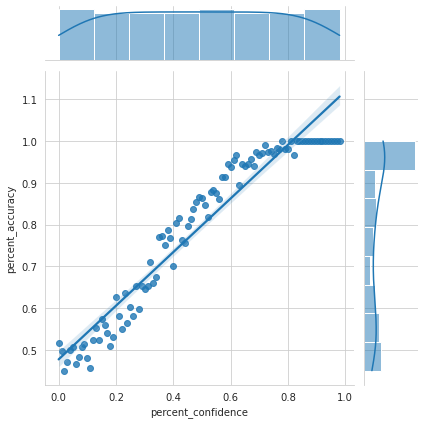

In [14]:
# repeat of the stuff to determine model accuracy at confidence levels
confidence_results = []
for confidence in range(0, 99):
    percent_confidence = confidence / 100
    correct_predictions = total_predictions = 0
    for _, match in qualification_matches.sample(n=300).iterrows():
        red_alliance_keys = [match['red_1_key'], match['red_2_key'], match['red_3_key']]
        blue_alliance_keys = [match['blue_1_key'], match['blue_2_key'], match['blue_3_key']]

        red_interval = score_model_complete.predict_alliance_confidence(red_alliance_keys, percent_confidence)
        blue_interval = score_model_complete.predict_alliance_confidence(blue_alliance_keys, percent_confidence)

        if not ((red_interval[0] < blue_interval[0] < red_interval[1])
                or (red_interval[0] < blue_interval[1] < red_interval[1])
                or (blue_interval[0] < red_interval[0] < blue_interval[1])
                or (blue_interval[0] < red_interval[1] < blue_interval[1])):
            total_predictions += 1

            actual_victor = 'red' if match['red_points_scored'] > match['blue_points_scored'] else 'blue'
            predicted_victor = 'red' if red_interval[0] > blue_interval[1] else 'blue'
            if actual_victor == predicted_victor:
                correct_predictions += 1

    percent_accuracy = correct_predictions / total_predictions
    confidence_results.append([percent_confidence, percent_accuracy])
confidence_results_df = pd.DataFrame(confidence_results, columns=['percent_confidence', 'percent_accuracy'])
sns.jointplot('percent_confidence', 'percent_accuracy', data=confidence_results_df, kind='reg')

The heck is up with that performance drop around 80% confidence? Something to look into for later. Almost back in business though.

## Visualizing teams

`teamvis.ipynb`

This compares against every match though. Keep that in mind.

Text(0.5, 1.0, 'Percentile plot of team_score for frc5160')

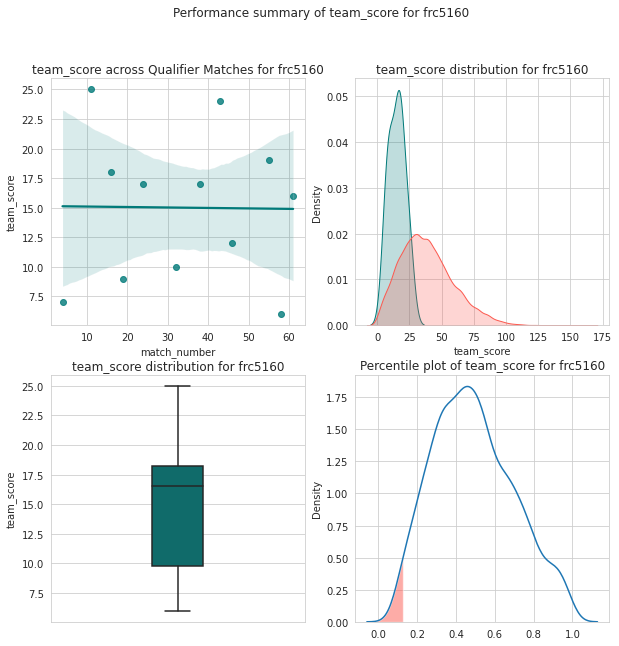

In [17]:
# get team data
team_key = 'frc5160'
matches_played = qualification_matches.loc[
    (team_key == qualification_matches["blue_1_key"]) |
    (team_key == qualification_matches["blue_2_key"]) |
    (team_key == qualification_matches["blue_3_key"]) |
    (team_key == qualification_matches["red_1_key"]) |
    (team_key == qualification_matches["red_2_key"]) |
    (team_key == qualification_matches["red_3_key"])
    ]
match_scores = team_scores.loc[team_scores['team_key'] == team_key]

primary_color = sns.xkcd_rgb['bluegreen']
secondary_color = sns.xkcd_rgb['coral']
background_color = sns.xkcd_rgb['white']

feature = 'team_score'

plt.figure(figsize=(10, 10))
plt.suptitle(f'Performance summary of {feature} for {team_key}')

# team performance across matches
plt.subplot(2, 2, 1)
sns.regplot(x='match_number', y=feature, data=match_scores, color=primary_color)
plt.title(f'{feature} across Qualifier Matches for {team_key}')

# "histogram" of scoring metrics
plt.subplot(2, 2, 2)
sns.kdeplot(match_scores[feature], shade=True, color=primary_color, label=f'{team_key}')
sns.kdeplot(team_scores[feature], shade=True, color=secondary_color, label='Overall')
plt.title(f'{feature} distribution for {team_key}')

# boxplot of team performance
plt.subplot(2, 2, 3)
sns.boxplot(y=feature, color=primary_color, data=match_scores, width=.2)
plt.title(f'{feature} distribution for {team_key}')

# percentile/curve of feature
plt.subplot(2, 2, 4)
event_mean, event_std = np.mean(team_scores[feature]), np.std(team_scores[feature])
team_data_key = 'mean_score' if feature == 'team_score' else f'mean_{feature}'
event_percentiles = stats.norm.cdf((team_data[team_data_key] - event_mean) / event_std)
percentile = stats.norm.cdf((np.mean(match_scores[feature]) - event_mean) / event_std)
ax = sns.kdeplot(event_percentiles)
line = ax.get_lines()[-1]
x, y = line.get_data()
mask = x < percentile
x, y = x[mask], y[mask]
ax.fill_between(x, y1=y, alpha=.5, facecolor=secondary_color)
plt.title(f'Percentile plot of {feature} for {team_key}')

## better event simulation

tl;dr this needs a way to simulate an event/do predictions without having data from other matches played in the (relative) future leak into the present being simulated. This can be done by simply only running the model on matches before a given point.

In [18]:
event_key = 'week2/2022ncgre'

qualifiers, unplayed, team_scores, team_data, _ = load_data_event(event_key)

def get_matches_before(match_num):
    qs = qualifiers.loc[qualifiers["match_number"] <= match_num]
    unp = qualifiers.loc[qualifiers["match_number"] > match_num]
    unp = pd.concat((unp, unplayed), axis=0)
    unp = unp[unplayed.columns]
    return qs, unp
